In [1]:
#this defaults plots to matplotlib 1.0 formatting
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

# importing packages needed to run this script 
from subprocess import call
import pickle as pickle
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
from math import floor

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import colorsys
import requests
import matplotlib.image as mpimg
from IPython.display import display
from IPython.display import Image
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import scipy.stats as stats
# import mpld3
import pickle as pickle
from optparse import OptionParser
import sys
sys.path.append('../../utilities')
sys.path.append('..')
from pysca import scaTools as sca
from graph_helpers import (
   gen_amino_acid_position_in_ref_sequence_graph,
   gen_clustered_similarity_matrix, 
   gen_unclustered_similarity_matrix,
   gen_pairwise_sequence_identities,
   gen_eigenvalues_graph
)
from helpers import (
    show_processmsa_results,
    seq_count_check
)

%matplotlib inline

if not os.path.exists('../output/'):
    os.makedirs('../output/')  

In [2]:
dbname = "HMGCRCTERM-aligned.db"
pickle_path = './HMGCRCTERM-aligned.db'
db = pickle.load(open(pickle_path,'rb'))
Dseq = db['sequence']
Dsca = db['sca']
Dsect = db['sector'] if db['sector'] else None

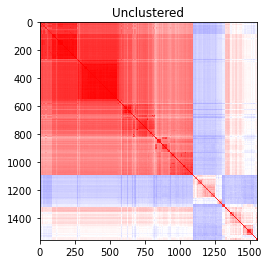

In [3]:
#check similarity matrix
gen_unclustered_similarity_matrix(title="Unclustered",Dsca=[Dsca])

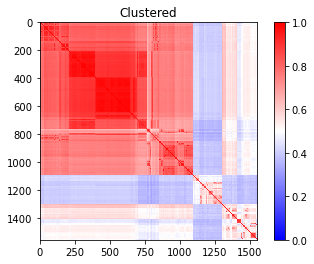

In [4]:
gen_clustered_similarity_matrix(title="Clustered", Dsca=[Dsca])

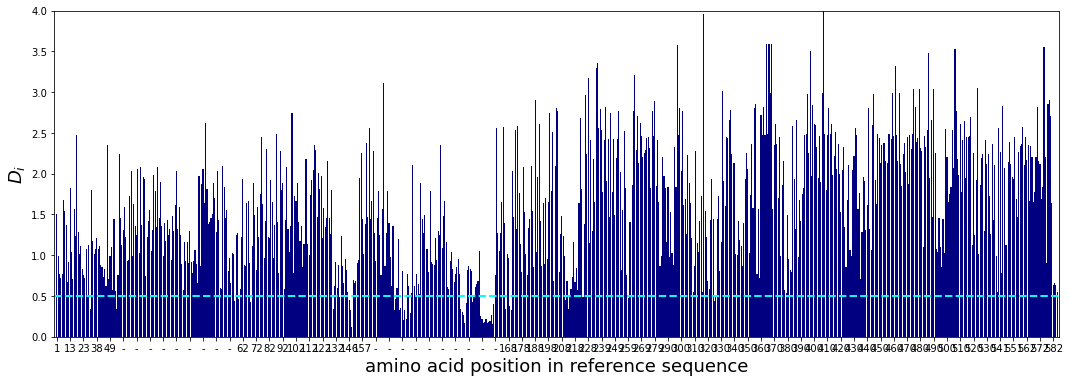

In [5]:
#Visualizing evolutionary conservation
gen_amino_acid_position_in_ref_sequence_graph(
    xlabel='amino acid position in reference sequence', 
    Dsca=[Dsca], 
    Dseq=[Dseq]
)

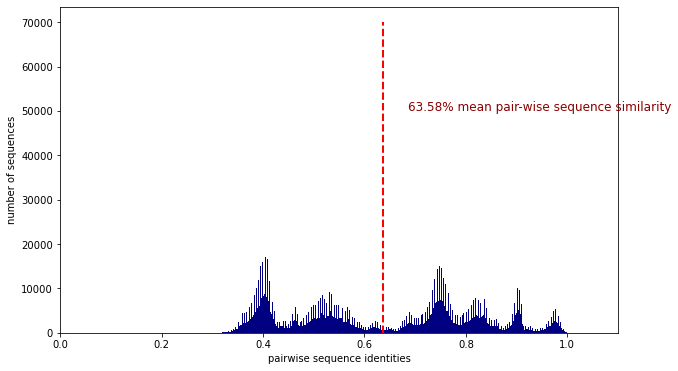

In [6]:
gen_pairwise_sequence_identities([Dseq],[Dsca])

Number of eigenmodes to keep is 17


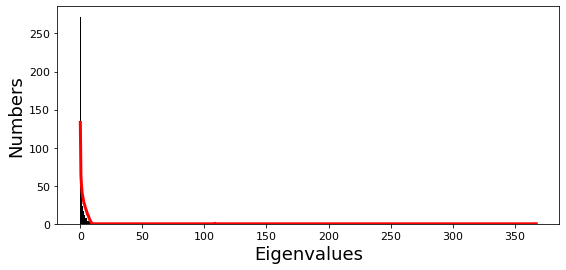

In [7]:
gen_eigenvalues_graph([Dseq],[Dsca],[Dsect])

Number of eigenmodes to keep is 17

cyan - distribution of eigenvalues of SCA matrix
red - distribution of eigenvalues from decomposition of randomized matrix


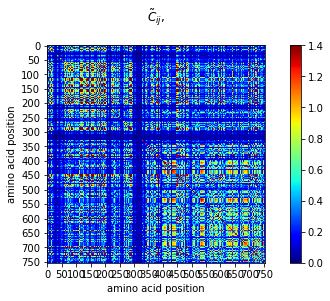

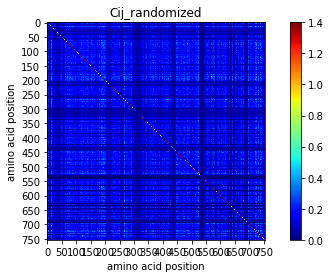

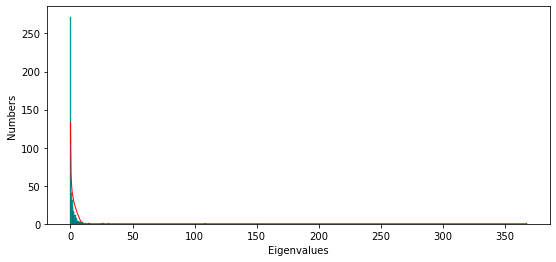

In [8]:

### initialize variables for visualizing the SCA matrix ######

sca_matrix = Dsca['Csca'] #pull out Cij matrix

minCorrelation = 0
maxCorrelation = 1.4

title = '$\~C_{ij}$,\n' # change title of figure to whatever you want
###############################################################

plt.figure()
plt.title(title)
plt.imshow(sca_matrix,cmap = 'jet',vmin=minCorrelation,vmax=maxCorrelation,interpolation='none',aspect='equal')

plt.xlabel('amino acid position') #inserts legend
plt.ylabel('amino acid position')

plt.xticks(np.arange(0,len(Dseq['ats']),50)) #places an xtick every 50 positions on this axis
plt.yticks(np.arange(0,len(Dseq['ats']),50))

plt.colorbar() # Shows the legend

plt.figure()
plt.title('Cij_randomized')
plt.imshow(Dsca['Crand'], cmap = 'jet', vmin = minCorrelation, vmax = maxCorrelation, interpolation = 'none', aspect = 'equal')

plt.xlabel('amino acid position') #inserts legend
plt.ylabel('amino acid position')

plt.xticks(np.arange(0,len(Dseq['ats']),50)) #places an xtick every 50 positions on this axis
plt.yticks(np.arange(0,len(Dseq['ats']),50))

plt.colorbar() # Shows the legend


###############################################################
plt.figure()
#distribution of eigenvalues
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'],range=(0,Dsect['Lsca'].max()))

hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'],range=(0,Dsect['Lsca'].max()))

plt.bar(bins[:-1], hist1, np.diff(bins),color='c',edgecolor = 'k',linewidth = 0.2) #dist of eigenvalues

plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=1)

plt.xlabel('Eigenvalues', fontsize=10)
plt.ylabel('Numbers', fontsize=10)

print('Number of eigenmodes to keep is %i' %(Dsect['kpos'])) #Dsect['kpos'] stores number of significant eigenmodes

#This is hard to see so zoom in
#plt.ylim(-0.5,5) #comment if you want to see the whole thing
#plt.xlim()

print ('')
print('cyan - distribution of eigenvalues of SCA matrix')
print('red - distribution of eigenvalues from decomposition of randomized matrix')


In [9]:
annot = dict()
for i, h in enumerate(Dseq['hd']):
    hs = h.split('|')
    annot[hs[0]] = sca.Annot(hs[1], hs[2], hs[3].replace('.','')) 

In [10]:
# Most frequent taxonomic groups:
atleast = 1
for level in range(4):
    descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                if len(a.taxo.split(',')) > level]
    descr_dict = {k:descr_list.count(k) for k in descr_list \
                if descr_list.count(k)>=atleast}
    print('\n Level %i:' % level)
    print(descr_dict)


 Level 0:
{'Eukaryota': 1555}

 Level 1:
{' Metazoa': 1353, ' Fungi': 200, ' Filasterea': 2}

 Level 2:
{' Chordata': 1100, ' Dikarya': 161, ' Fungi incertae sedis': 39, ' Capsaspora': 2, ' Ecdysozoa': 232, ' Echinodermata': 4, ' Spiralia': 12, ' Placozoa': 2, ' Porifera': 1, ' Cnidaria': 2}

 Level 3:
{' Craniata': 1094, ' Basidiomycota': 160, ' Zoopagomycota': 4, ' Ascomycota': 1, ' Chytridiomycota': 2, ' Mucoromycota': 33, ' Arthropoda': 230, ' Eleutherozoa': 4, ' Lophotrochozoa': 12, ' Cephalochordata': 6, ' Trichoplacidae': 2, ' Tardigrada': 2, ' Demospongiae': 1, ' Anthozoa': 2}


In [11]:
phylo = list();
fam_names = ['Metazoa', 'Fungi', 'Filasterea']
col = (0, 0.8, 0.38)
#Metazoa = red, Fungi = purple, Filasterea = green,

for i,k in enumerate(fam_names):
    sf = sca.Unit()
    sf.name = fam_names[i].lower()
    sf.col = col[i]
    sf.items = [j for j,q in enumerate(Dseq['hd'])  if sf.name in q.lower()]
    phylo.append(sf)

ValueError: num must be 1 <= num <= 6, not 7

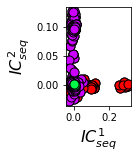

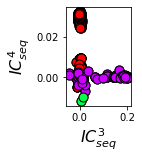

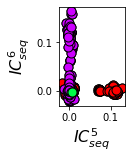

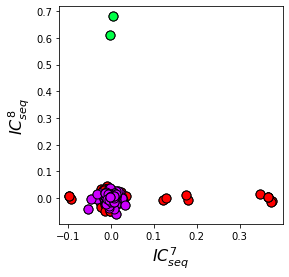

In [28]:
plt.rcParams['figure.figsize'] = 9, 8
U = Dsca['Uica'][1]
pairs = [[2*i,2*i+1] for i in range(floor(Dsect['kpos']/2))] # BUG NEED TO COMPARE ALL PAIRS OF FIRST 6 TOP EIGEN MODES 
for k,[k1,k2] in enumerate(pairs):
    plt.figure(figsize = (4,4))
    sca.figUnits(U[:,k1], U[:,k2], phylo) 
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    plt.subplot(2,3,k+4)
    sca.figUnits(U[:,k1], U[:,k2], phylo)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    

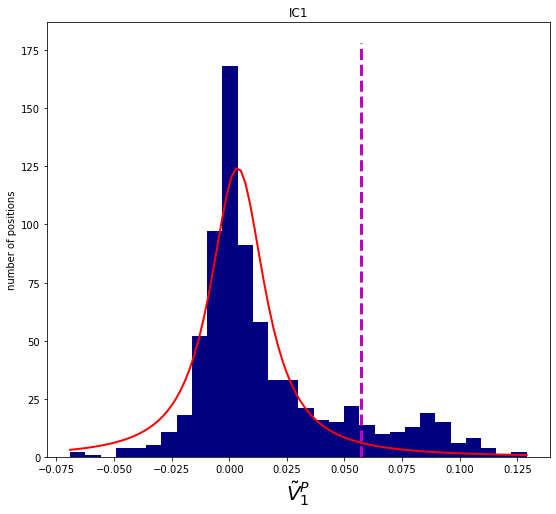

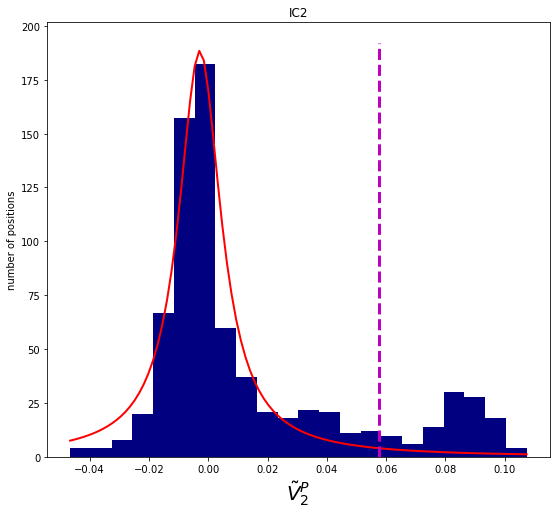

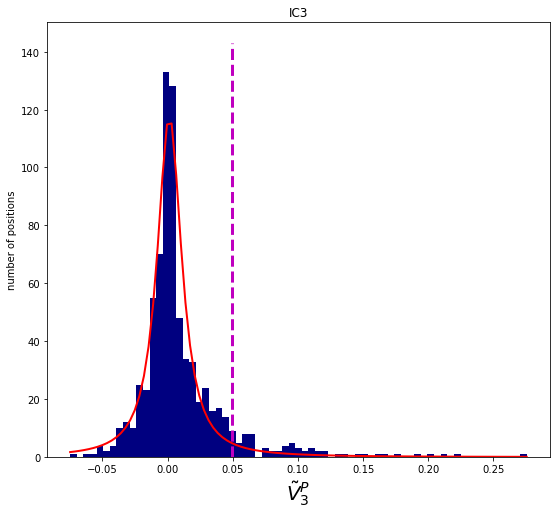

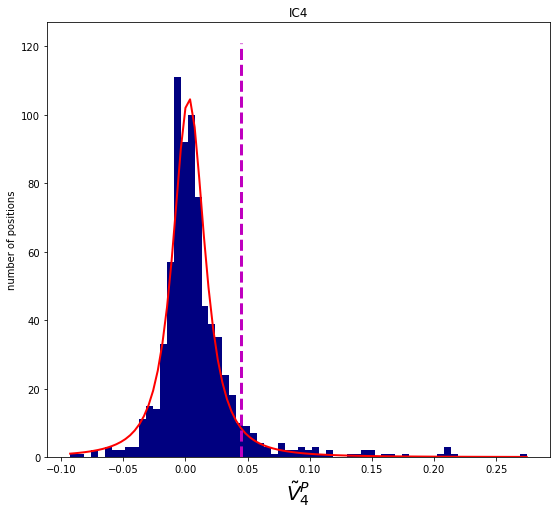

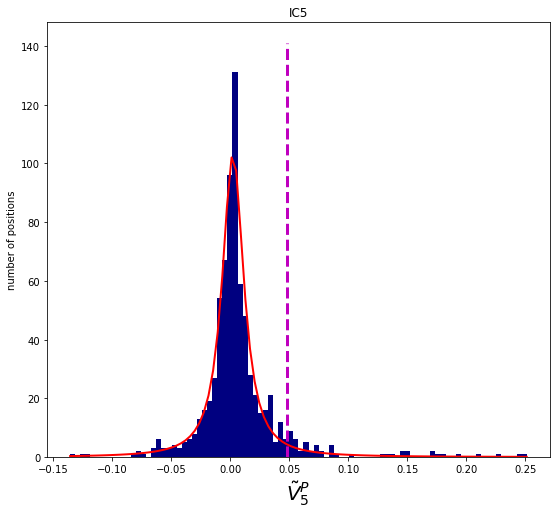

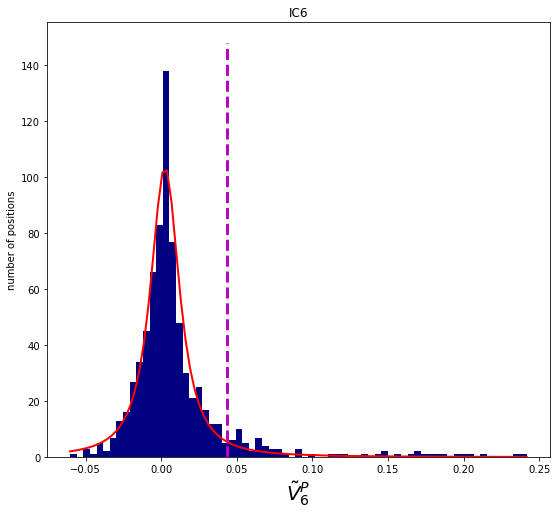

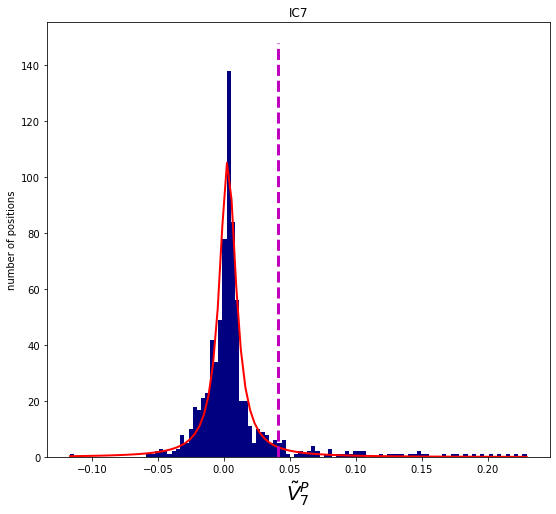

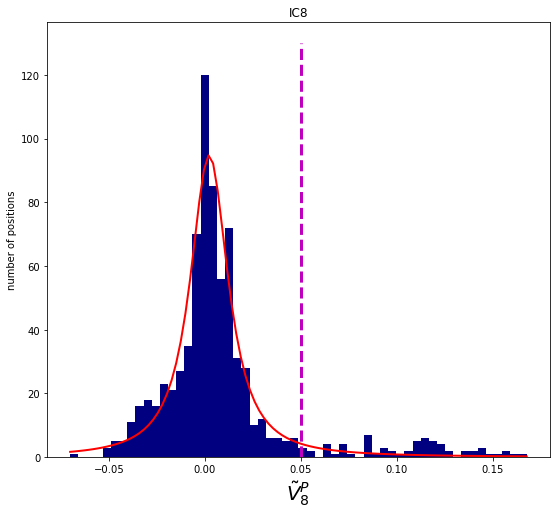

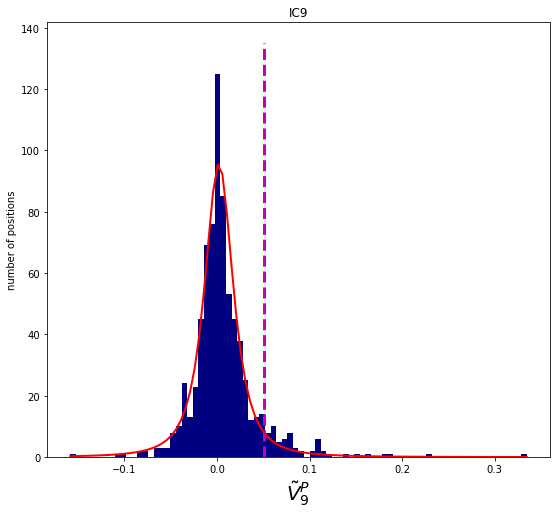

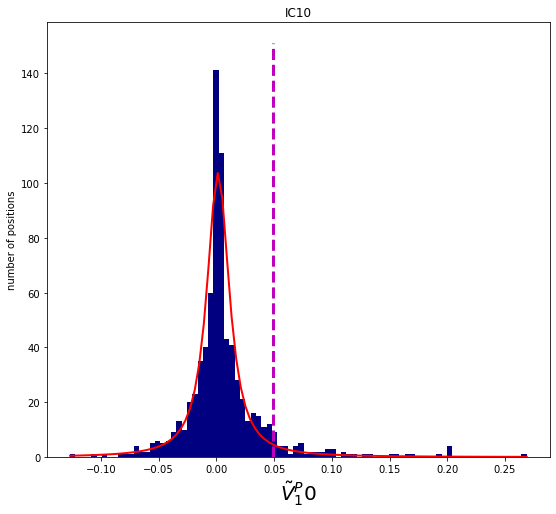

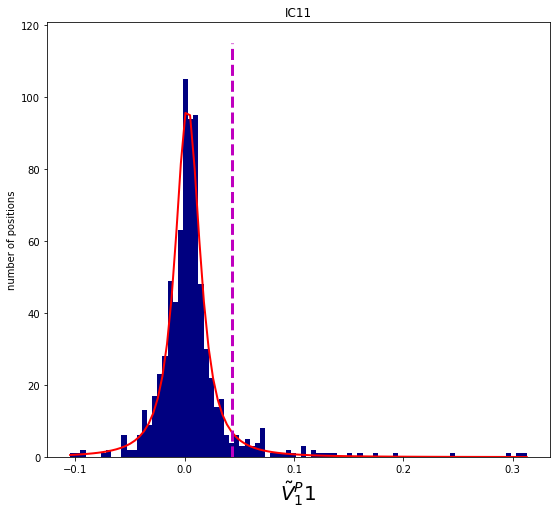

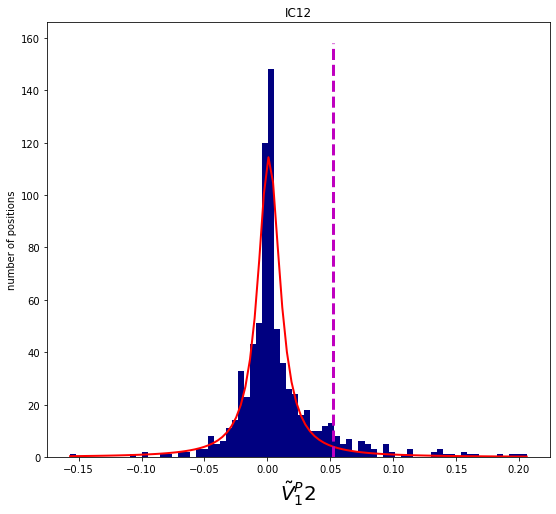

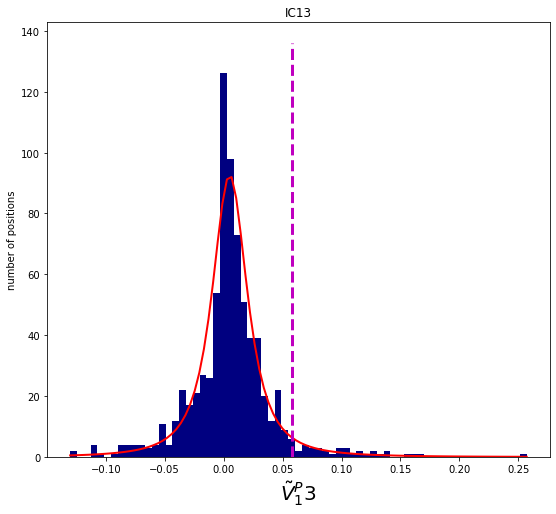

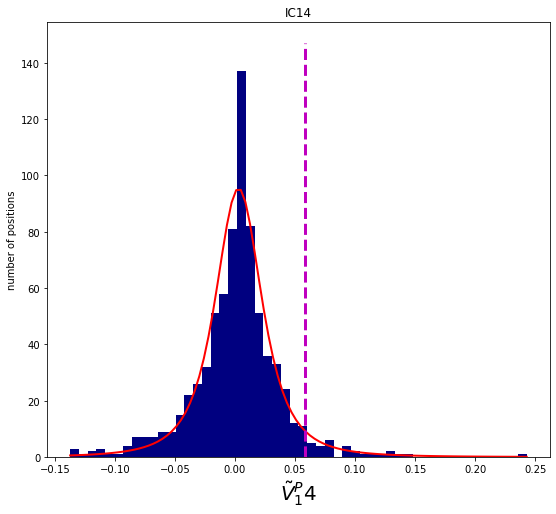

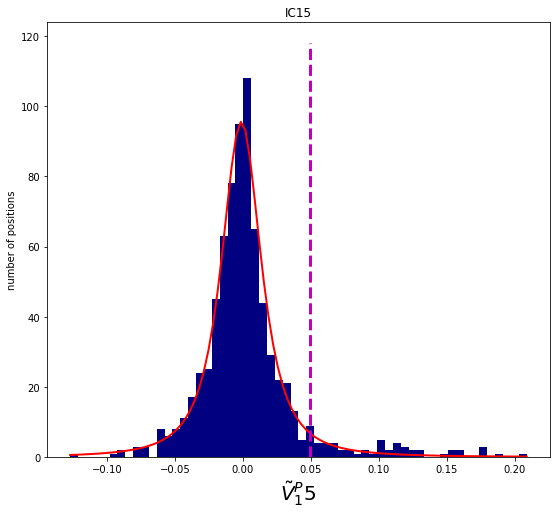

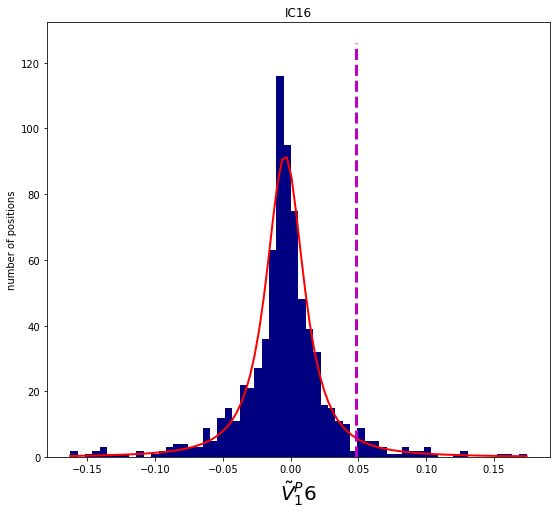

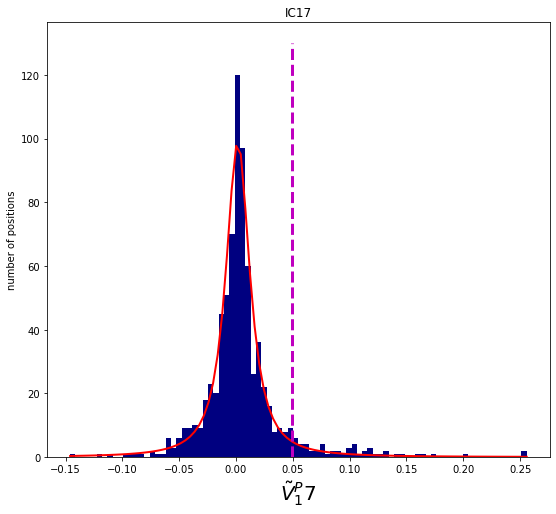

In [13]:
# plot histogram of each IC

independentComponents = Dsect['Vpica']
for k in range(Dsect['kpos']): #iterate through each significant IC 
    
    # determine number of bins for the histogram based on interquartile range
    iqr = stats.scoreatpercentile(independentComponents[:,k],75) - stats.scoreatpercentile(independentComponents[:,k],25)
    binWidth = 2*iqr*(len(independentComponents[:,k])**(-0.33))
    nBins = int(round((max(independentComponents[:,k]) - min(independentComponents[:,k]))/binWidth))

    #plot histogram of values in each IC
    plt.figure()
    h_params = plt.hist(independentComponents[:,k], nBins,color = 'navy')
        #output of histogram are the height of each bin and their x-positions 
    
    # plot t-distribution of each IC 
    x_dist = np.linspace(min(h_params[1]), max(h_params[1]), num=100)
    plt.plot(x_dist,Dsect['scaled_pd'][k],'r',linewidth = 2)  


    # plot defined significance cut-off 
    plt.plot([Dsect['cutoff'][k],Dsect['cutoff'][k]],[0,max(h_params[0])+10],'--m',linewidth = 3)
    plt.title('IC'+str(k+1))
    plt.ylabel('number of positions')
    plt.xlabel('$\~{V}^P_%i$'%(k+1),fontsize=20)


In [14]:
for n,ipos in enumerate(Dsect['ics']):
    sort_ipos = sorted(ipos.items)
    ats_ipos = ([str(Dseq['ats'][s]) for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
    print(ic_pymol + "\n")
'+'.join([str(Dseq['ats'][s]) for s in sort_ipos])

IC 1 is composed of 101 positions:
1+9+10+13+14+16+17+19+20+21+28+30+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+55+57+61+62+65+66+70+71+75+79+82+84+85+86+88+96+98+101+103+105+109+110+113+114+118+120+138+150+153+154+155+156+157+159+164+-+-+-+-+-+-+-+-+-+184+186+192+200+210+217+255+262+276+280+290+323+358+369+417+423+466+482+494+526+536+551+554+574

IC 2 is composed of 112 positions:
87+90+162+175+191+201+204+205+222+228+231+235+236+237+238+239+241+246+248+251+252+253+263+264+265+266+268+269+271+273+274+275+277+278+279+281+297+299+301+311+317+331+334+335+336+340+349+355+360+361+362+363+364+365+366+367+368+370+371+372+374+393+394+395+397+399+400+401+404+406+407+410+411+412+413+415+416+430+431+444+445+448+449+452+453+456+457+459+460+462+463+464+468+472+474+475+476+478+479+481+483+484+485+486+488+491+508+523+558+561+565+575

IC 3 is composed of 52 positions:
11+46+-+-+-+-+-+-+-+-+-+-+-+-+-+89+94+99+108+111+122+158+-+-+-+-+-+-+-+-+168+194+209+223+243+287+315+328+332+343+347+353+376+396+405+42

'-+-+160+-+-+198+402+454+549'

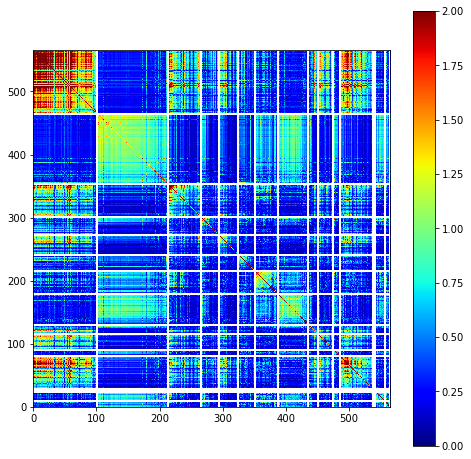

In [15]:
plt.rcParams['figure.figsize'] = 8,8
plt.figure()
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2,cmap = 'jet',interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i] 
#plt.title('Positional correlations by contribution to top ICs',fontweight='bold')
plt.colorbar()
#plt.savefig('fig_dhfr_icsHeatmap.pdf',fmt = 'pdf')

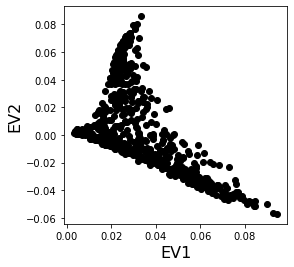

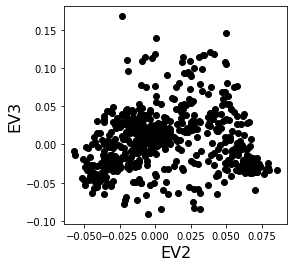

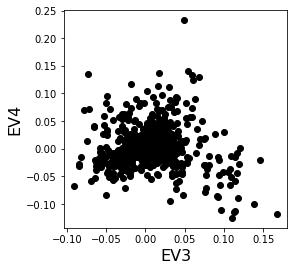

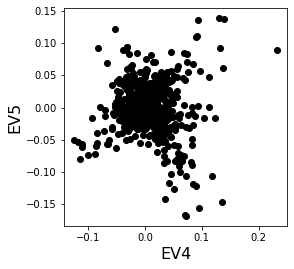

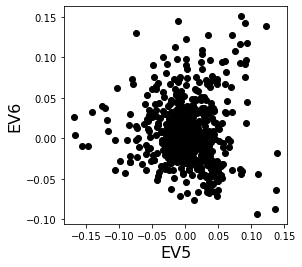

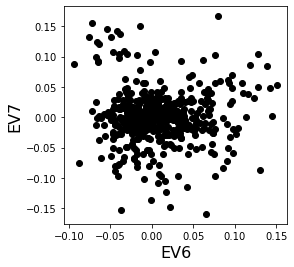

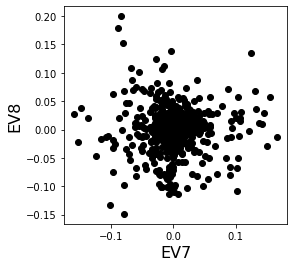

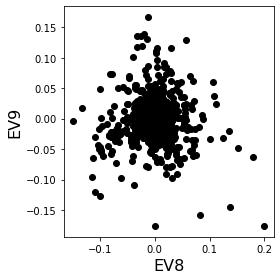

In [17]:
plt.rcParams['figure.figsize'] = 9, 6
pairs = [[i,i+1] for i in range(floor(Dsect['kpos']/2))]
EVs = Dsect['Vsca']
ICs = Dsect['Vpica']
for k,[k1,k2] in enumerate(pairs):
    plt.figure(figsize = (4,4))
    plt.plot(EVs[:,k1], EVs[:,k2], 'ok')
    plt.xlabel("EV%i"%(k1+1), fontsize=16)
    plt.ylabel("EV%i"%(k2+1), fontsize=16)
plt.tight_layout()

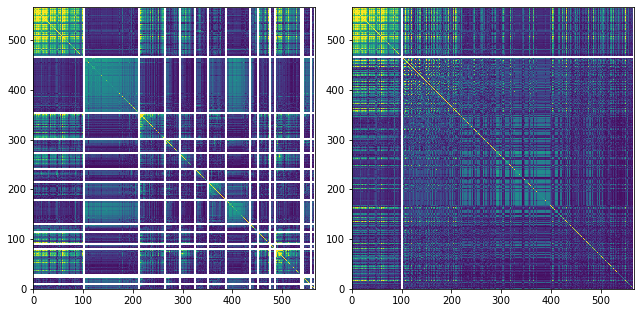

In [22]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 9, 9
plt.subplot(121)
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2.2,interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i]

#define the new sector groupings - 3 total
inSector =[0]
notSector =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
sectors = list()

sec_groups = (inSector, notSector)
c = [0.66, 0]
for n,k in enumerate(sec_groups):
    s = sca.Unit()
    all_items = list()
    all_Vp = list()
    for i in k:
        all_items = all_items+Dsect['ics'][i].items
        all_Vp = all_Vp+list(Dsect['ics'][i].vect)
    svals = np.argsort(all_Vp)
    s.items = [all_items[i] for i in svals]
    s.col = c[n]
    sectors.append(s)

#plot the re-ordered matrix
plt.subplot(122)
line_index=0
sortpos = list()
for s in sectors:
    sortpos.extend(s.items)
plt.imshow(Dsca['Csca'][np.ix_(sortpos, sortpos)], vmin=0, vmax=2.2,\
           interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
for s in sectors:
    plt.plot([line_index+len(s.items),line_index+len(s.items)],\
             [0,len(sortpos)],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[len(sortpos)-line_index,\
                    len(sortpos)-line_index],'w', linewidth = 2)
    line_index += len(s.items)
plt.tight_layout()

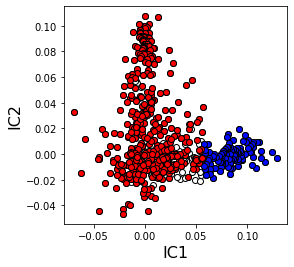

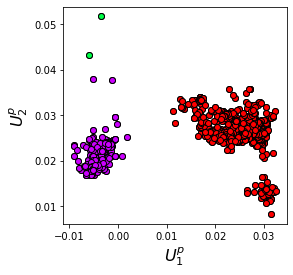

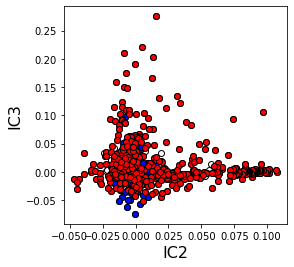

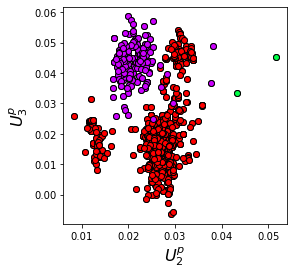

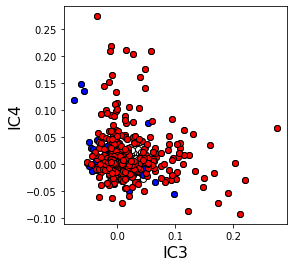

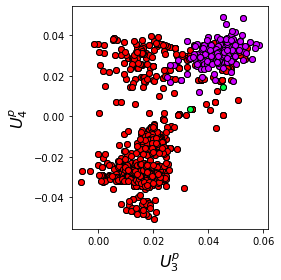

In [23]:
plt.rcParams['figure.figsize'] = 14, 10
pairs= [[0,1],[1,2],[2,3]]
for n,[k1,k2] in enumerate(pairs):
    plt.figure(figsize=(4,4))
    sca.figUnits(Dsect['Vpica'][:,k1], Dsect['Vpica'][:,k2], \
                 sectors, dotsize = 6)
    plt.xlabel('IC%i' % (k1+1), fontsize=16)
    plt.ylabel('IC%i' % (k2+1), fontsize=16)
    
    plt.figure(figsize = (4,4))
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 phylo, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
plt.tight_layout()

In [26]:
for i,el in enumerate(Dseq['ats']):
    Dseq['ats'][i] = str(el)
for i,k in enumerate(sectors):
    sort_ipos = sorted(k.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
    print(ic_pymol + "\n")
sca.writePymol('5P21', sectors, Dsect['ics'], Dseq['ats'], \
               './HMGCRsector.pml','A', '../Inputs/', 0)

Sector 1 is composed of 101 positions:
1+9+10+13+14+16+17+19+20+21+28+30+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+55+57+61+62+65+66+70+71+75+79+82+84+85+86+88+96+98+101+103+105+109+110+113+114+118+120+138+150+153+154+155+156+157+159+164+-+-+-+-+-+-+-+-+-+184+186+192+200+210+217+255+262+276+280+290+323+358+369+417+423+466+482+494+526+536+551+554+574

Sector 2 is composed of 465 positions:
6+11+18+22+24+41+44+46+49+50+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+58+67+72+73+74+76+77+80+83+87+89+90+91+92+94+95+97+99+100+102+104+106+108+111+115+116+117+119+121+122+123+124+125+126+127+129+136+139+151+158+160+161+162+163+165+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+167+168+172+173+174+175+176+177+179+180+183+185+188+189+190+191+194+195+196+198+199+201+203+204+205+208+209+211+212+220+221+222+223+225+226+227+228+229+231+232+233+234+235+236+237+238+239+240+241+242+243+244+245+246+247+248+249+250+251+252+253+256+257+260+263+2

/tmp/ipykernel_1840/26027897.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4,4))


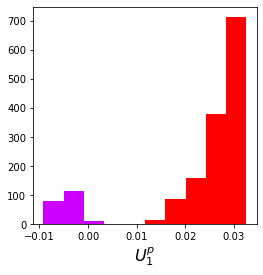

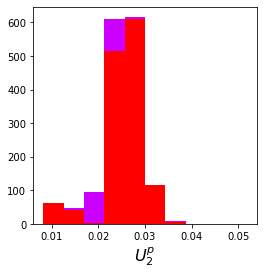

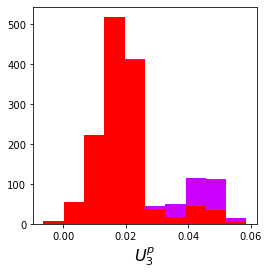

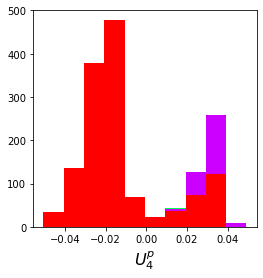

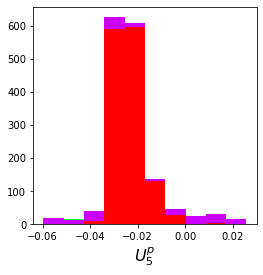

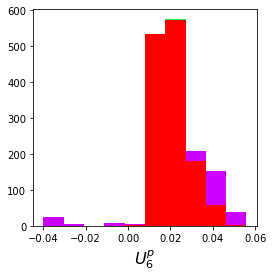

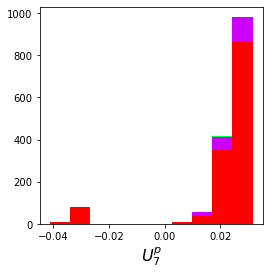

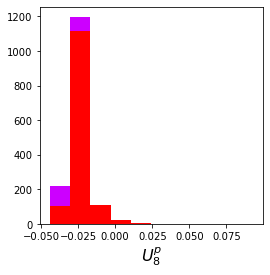

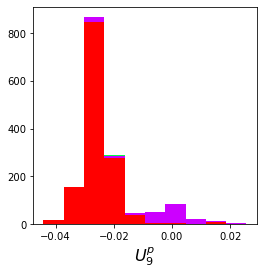

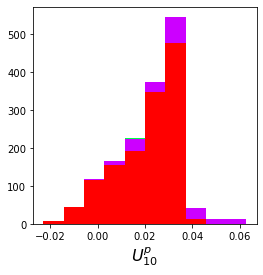

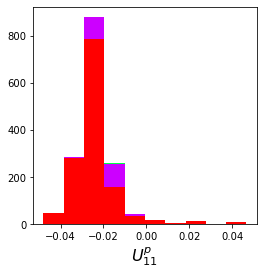

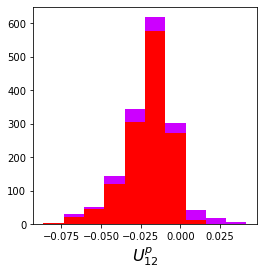

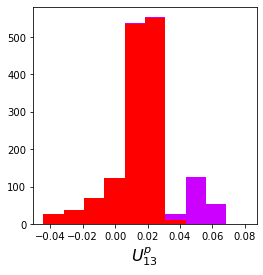

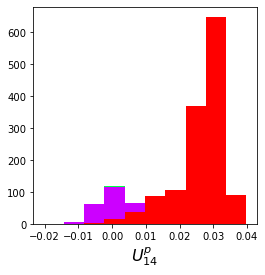

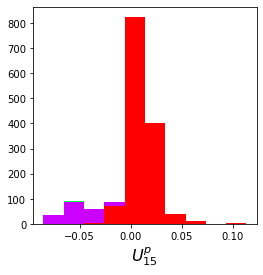

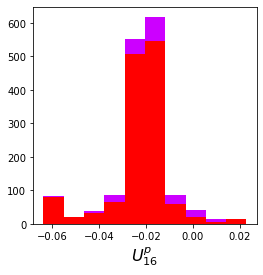

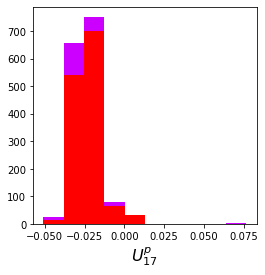

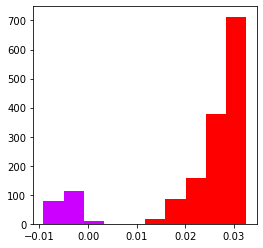

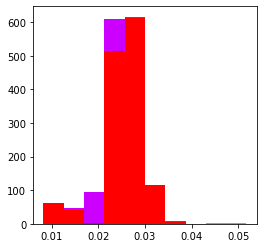

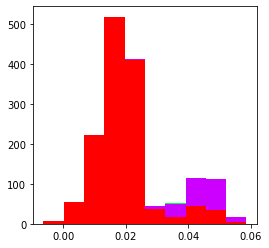

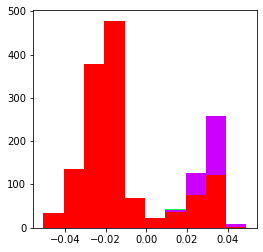

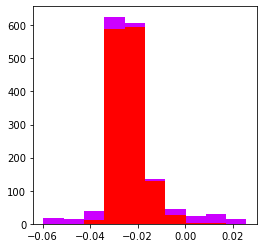

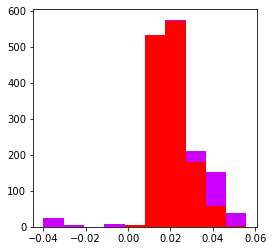

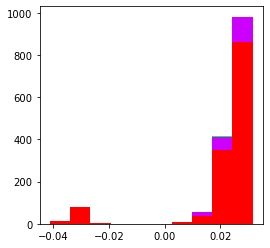

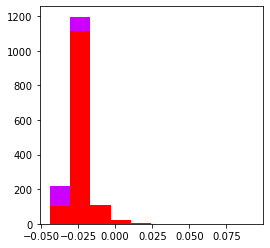

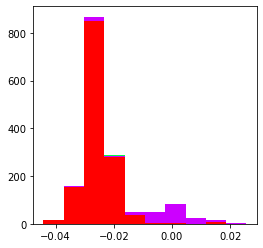

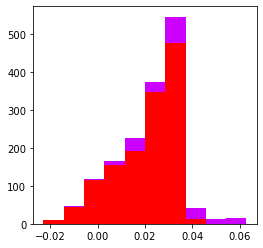

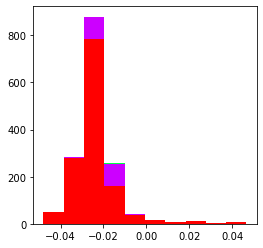

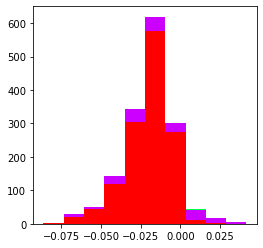

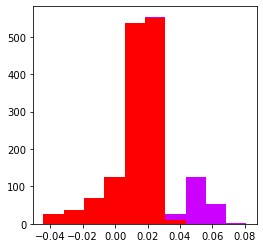

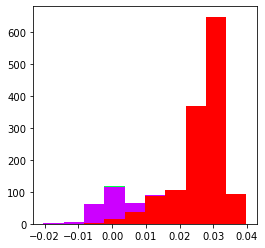

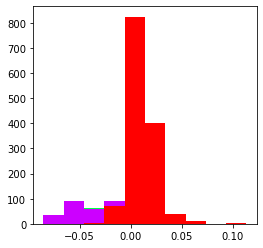

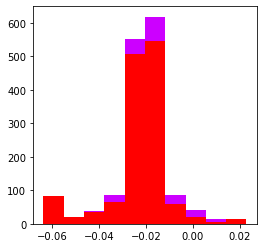

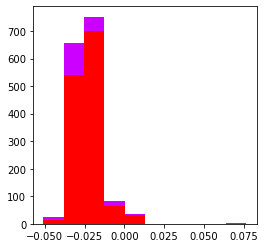

In [27]:
plt.rcParams['figure.figsize'] = 15, 4


col = list()
for k in phylo:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in phylo:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.figure(figsize=(4,4))
    plt.hist(forhist, histtype='barstacked',color=col)
    plt.xlabel(r'$U^p_{%i}$' % (k+1), fontsize=16)

col = list()
for k in phylo:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in phylo:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.figure(figsize=(4,4))
    plt.hist(forhist, histtype='barstacked',color=col)